In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.cm import ScalarMappable
from PIL import Image as imge
from keras.models import Sequential, Model, load_model
from keras import callbacks
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.optimizers import Adam
import datetime
import os
import keras
import keras.regularizers as l2
import pickle
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Model
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.graph_objects as go
import seaborn as sns
import sklearn.metrics
import keras.datasets.fashion_mnist as fashion_mnist

2023-02-25 11:57:18.734039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Task 6:
## Task 6.1

In [2]:
'''Code for loading the dataset''' 
def load_data():
    #train_X: (60000, 28, 28)
    #train_y: (60000,)
    #test_X: (10000, 28, 28)
    #test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    #map to new label
    train_y_2 = list (0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)
    test_y_2  = list (0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    #train_X: (60000, 28, 28, 1)
    #test_X: (10000, 28, 28, 1)
    #train_y: (60000, n_class = 10)
    #test_y: (10000, n_class = 3)
    train_X = np.expand_dims (train_X, axis=3)
    test_X = np.expand_dims (test_X, axis=3)
    train_y_1 = to_categorical (train_y_1, n_class_1)
    test_y_1= to_categorical (test_y_1, n_class_1)
    train_y_2=to_categorical (train_y_2, n_class_2)
    test_y_2 = to_categorical (test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2
x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2= load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
groups_names = ['Shoes', 'Gendered', 'Uni_Sex']

# rescaling data to [0, 1] 
x_train = (x_train)/255
x_test = (x_test)/255

we construct the first CNN classfier for item classification 

In [60]:
# building the task 1, 10-class classification 
classification_cnn = Sequential()
classification_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name = 'Conv2D_1'))
classification_cnn.add(MaxPooling2D((2, 2), strides = 2))

classification_cnn.add(Conv2D(64, (3, 3),  activation='relu', name = 'Conv2D_2'))
classification_cnn.add(MaxPooling2D((2, 2), strides = 2))

classification_cnn.add(Conv2D(128, (3, 3), activation='relu', name = 'Conv2D_3'))
classification_cnn.add(Flatten())

classification_cnn.add(Dense(3136, activation='relu', name='FCN_1'))
classification_cnn.add(Dense(1024, activation='relu', name = 'FCN_2'))
classification_cnn.add(Dense(100, activation='relu', name = 'FCN_3'))
classification_cnn.add(Dense(10, activation='softmax', name = 'classification_head'))

classification_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 Conv2D_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 Conv2D_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

In [61]:
# compile model and fit it to data
classification_cnn.compile(loss= 'categorical_crossentropy',
                           optimizer= Adam(learning_rate=0.001),
                           metrics= ['accuracy'])

batch_size = 10
classification_cnn_history = classification_cnn.fit(
    x_train, y_train_1, batch_size = batch_size,
    epochs=5, validation_split = 0.2)

Epoch 1/5
4800/4800 [==============================] - 379s 79ms/step - loss: 0.5062 - accuracy: 0.8132 - val_loss: 0.3842 - val_accuracy: 0.8608
Epoch 2/5
4800/4800 [==============================] - 357s 74ms/step - loss: 0.3465 - accuracy: 0.8749 - val_loss: 0.3474 - val_accuracy: 0.8726
Epoch 3/5
4800/4800 [==============================] - 382s 80ms/step - loss: 0.3067 - accuracy: 0.8894 - val_loss: 0.3057 - val_accuracy: 0.8913
Epoch 4/5
4800/4800 [==============================] - 363s 76ms/step - loss: 0.2804 - accuracy: 0.8981 - val_loss: 0.3023 - val_accuracy: 0.8876
Epoch 5/5
4800/4800 [==============================] - 396s 83ms/step - loss: 0.2573 - accuracy: 0.9070 - val_loss: 0.3120 - val_accuracy: 0.8892


In [62]:
_ , accuracy_class_cnn = classification_cnn.evaluate(x_test, y_test_1, verbose = 0)
print('Task 1 accuracy on the test set: %.2f' % (accuracy_class_cnn*100))

Task 1 accuracy on the test set: 88.40


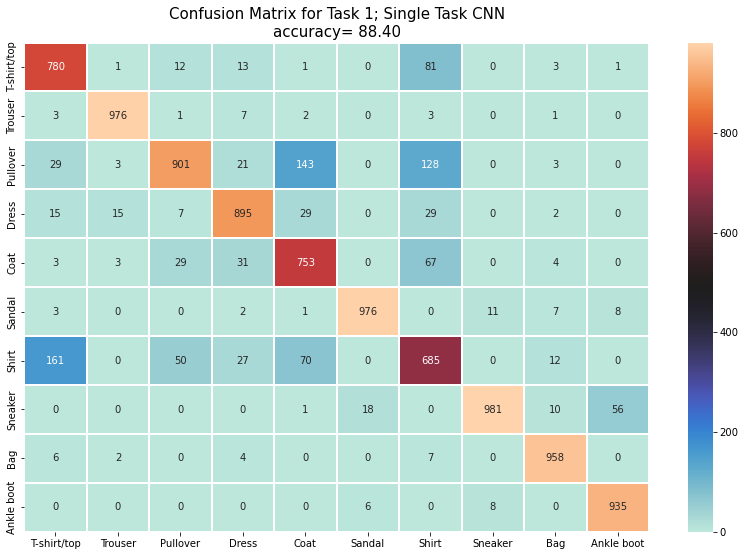

In [63]:
preds = classification_cnn.predict(x_test, verbose = 0)

plt.figure(figsize=(14, 9))
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test_1, axis=1)), 
            cmap='icefire', annot=True, fmt="", yticklabels=class_names, xticklabels=class_names, linewidths=0.1)

plt.title('Confusion Matrix for Task 1; Single Task CNN\naccuracy= %.2f' %(accuracy_class_cnn*100), fontsize=15);


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-15 22:34:21         4765
metadata.json                                  2023-02-15 22:34:21           64
variables.h5               

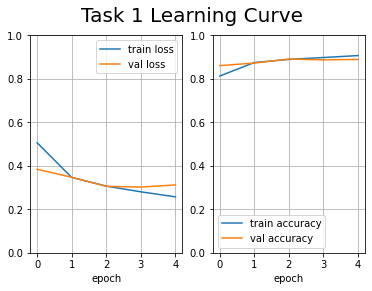

In [64]:
def plot_learing_curve(history, title):
    # plot the learning curves
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid(True)
    plt.ylim([0,1.0])
    plt.xlabel('epoch')
    
    
    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim([0,1.0])
    plt.xlabel('epoch')
    plt.suptitle(title, fontsize=20)

    
# # # Calling `save('my_model')` creates a SavedModel folder `my_model`.
# classification_cnn.save('6_1_classification_cnn.h5')  #  save model after training
# np.save('6_1_classification_cnn_history.npy',classification_cnn_history)

# with open('6_1_classification_cnn_history.pkl', 'wb') as f:
#       pickle.dump(classification_cnn_history, f)

 # It can be used to reconstruct the model identically.
classification_cnn = load_model('6_1_classification_cnn.h5')
classification_cnn_history = np.load('6_1_classification_cnn_history.npy',allow_pickle='TRUE').item()
        
with open('6_1_classification_cnn_history.pkl', 'rb') as f:
    classification_cnn_history = pickle.load(f)

# plot the learning curves
plot_learing_curve(classification_cnn_history, 'Task 1 Learning Curve')

then create another model for group classification.

In [15]:
# building the task 2, 3-group categorization 
categorization_cnn = Sequential()
categorization_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1), name = 'Conv2D_1'))
categorization_cnn.add(MaxPooling2D((2, 2), strides = 2))

categorization_cnn.add(Conv2D(64, (3, 3),  activation='relu', name = 'Conv2D_2'))
categorization_cnn.add(MaxPooling2D((2, 2), strides = 2))

categorization_cnn.add(Conv2D(128, (3, 3), activation='relu', name = 'Conv2D_3'))
categorization_cnn.add(Flatten())

categorization_cnn.add(Dense(3136, activation='relu', name='FCN_1'))
categorization_cnn.add(Dense(1024, activation='relu', name = 'FCN_2'))
categorization_cnn.add(Dense(100, activation='relu', name = 'FCN_3'))
categorization_cnn.add(Dense(3, activation='softmax', name = 'categorization_head'))

categorization_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 Conv2D_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 Conv2D_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_6 (Flatten)         (None, 1152)             

In [16]:
categorization_cnn.compile(loss= 'categorical_crossentropy',
                           optimizer= Adam(learning_rate=0.001),
                           metrics= ['accuracy'])
batch_size = 10
categorization_cnn_history = categorization_cnn.fit(
    x_train, y_train_2, batch_size = batch_size,
    epochs=5, validation_split=0.2)

Epoch 1/5
4800/4800 [==============================] - 542s 112ms/step - loss: 0.2602 - accuracy: 0.8829 - val_loss: 0.2094 - val_accuracy: 0.9034
Epoch 2/5
4800/4800 [==============================] - 480s 100ms/step - loss: 0.1926 - accuracy: 0.9158 - val_loss: 0.2020 - val_accuracy: 0.8988
Epoch 3/5
4800/4800 [==============================] - 455s 95ms/step - loss: 0.1745 - accuracy: 0.9247 - val_loss: 0.1820 - val_accuracy: 0.9199
Epoch 4/5
4800/4800 [==============================] - 462s 96ms/step - loss: 0.1587 - accuracy: 0.9320 - val_loss: 0.1694 - val_accuracy: 0.9247
Epoch 5/5
4800/4800 [==============================] - 445s 93ms/step - loss: 0.1473 - accuracy: 0.9373 - val_loss: 0.1652 - val_accuracy: 0.9319


In [17]:
_,accuracy_categ_cnn = categorization_cnn.evaluate(x_test, y_test_2, verbose = 0)
print('Task 2 accuracy on the test set: %.2f' % (accuracy_categ_cnn*100))


Task 2 accuracy on the test set: 92.80


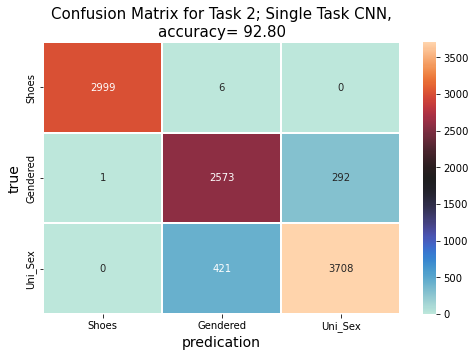

In [18]:
preds = categorization_cnn.predict(x_test, verbose = 0)

plt.figure(figsize=(8, 5))
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test_2, axis=1)), 
            cmap='icefire', annot=True, fmt="", yticklabels=groups_names, xticklabels=groups_names, linewidths=0.1)
plt.xlabel('predication', fontsize = 14)
plt.ylabel('true', fontsize = 14)
plt.title('Confusion Matrix for Task 2; Single Task CNN,\naccuracy= %.2f' %(accuracy_categ_cnn*100), fontsize=15);

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-18 12:09:12         4766
metadata.json                                  2023-02-18 12:09:12           64
variables.h5               

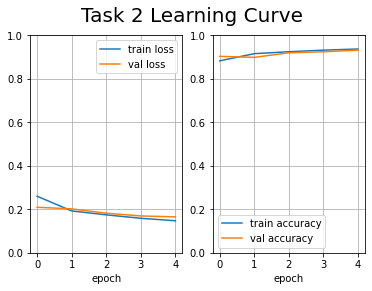

In [21]:
# # Calling `save('my_model')` creates a SavedModel folder `my_model`.
# categorization_cnn.save('6_1_categorization_cnn.h5')  #  save model after training
# np.save('6_1_categorization_cnn_history.npy',categorization_cnn_history)

# # It can be used to reconstruct the model identically.
categorization_cnn_model = load_model('6_1_categorization_cnn.h5')
categorization_cnn_history = np.load('6_1_categorization_cnn_history.npy',allow_pickle='TRUE').item()

# plot the learning curves
plot_learing_curve(categorization_cnn_history, 'Task 2 Learning Curve')

## Task 6.2:
Build a Multi-Task Learning model for the two MNIST fashion tasks. Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions. The output of the shared dense layer is passed to two series of task-specific dense layers, one for each of the two tasks.

In [4]:
def MTL(x_train,y_train_1, y_train_2, x_test, y_test_1,y_test_2, gamma): 
    #build the shared part of the network 
    shared = Sequential()
    shared.add(Conv2D(32, (3, 3), activation='relu', strides = 1, input_shape=(28, 28,1), name = 'Conv2D_1'))
    shared.add(MaxPooling2D((2, 2), strides = 2))

    shared.add(Conv2D(64, (3, 3),  activation='relu', strides = 1, name = 'Conv2D_2'))
    shared.add(MaxPooling2D((2, 2), strides = 2))

    shared.add(Conv2D(128, (3, 3), activation='relu', strides = 1, name = 'Conv2D_3'))
    shared.add(Flatten())
    shared.add(Dense(3136, activation='relu', name='FCN_1'))

    # collect it and feed input to it
    inputs = Input(shape=(28, 28,1))
    x = shared(inputs)
    
    # the first head with 10 output
    out_class = Dense(1024, activation='relu', name = 'FCN_2_1')(x)
    out_class = Dense(100, activation='relu', name = 'FCN_3_1')(out_class)
    out_class = Dense(10, activation='softmax', name = 'classification_head')(out_class)
    
    # the second head with 3 output
    out_group = Dense(1024, activation='relu', name = 'FCN_2_2')(x)
    out_group = Dense(100, activation='relu', name = 'FCN_3_2')(out_group)
    out_group = Dense(3, activation='softmax', name = 'categorization_head')(out_group)
    
    # build the model 
    MTL_model = Model(inputs=inputs, outputs={
        'out_class': out_class,
        'out_group': out_group})
    
    #compile it with custom weight function
    MTL_model.compile(loss= {
        'out_class': 'categorical_crossentropy',
        'out_group': 'categorical_crossentropy'},
                      loss_weights={'out_class': gamma, 
                                    'out_group': 1 - gamma}, 
                      optimizer= 'adam',
                      metrics=['accuracy'])
    
    #train the model with the data
    batch_size = 128
    history = MTL_model.fit(x_train, {
            'out_class': y_train_1, 
            'out_group': y_train_2},
        batch_size = batch_size,
        epochs= 5, validation_split=0.2)
    
    
    # evaluate against test data 
    _,_,_, classification_accuracy_MTL, categorization_accuracy_MTL = MTL_model.evaluate(x_test, {
        'out_class': y_test_1, 
        'out_group': y_test_2})
    
    return MTL_model, history, classification_accuracy_MTL, categorization_accuracy_MTL

In [5]:
history_collection = []
accuracies_mtl = []
for gamma in [0, 0.3, 0.5 , 0.7, 1]:
    
    MTL_model, history, classification_accuracy_MTL, categorization_accuracy_MTL = MTL(x_train,y_train_1,
                                                                                       y_train_2, x_test,
                                                                                       y_test_1,y_test_2, gamma)
    history_collection.append(history)
    accuracies_mtl.append((classification_accuracy_MTL, categorization_accuracy_MTL))
    MTL_model.save(f'6.2_mtl_cnn_{gamma}.h5')  #  save model after training
    np.save(f'6_2__mtl_cnn_{gamma}_history.npy',history)


2023-02-17 15:36:23.426664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
375/375 [==============================] - 178s 466ms/step - loss: 0.2702 - classification_head_loss: 2.3143 - categorization_head_loss: 0.2702 - classification_head_accuracy: 0.1288 - categorization_head_accuracy: 0.8757 - val_loss: 0.1911 - val_classification_head_loss: 2.3062 - val_categorization_head_loss: 0.1911 - val_classification_head_accuracy: 0.1212 - val_categorization_head_accuracy: 0.9162
Epoch 2/5
375/375 [==============================] - 186s 496ms/step - loss: 0.1788 - classification_head_loss: 2.3063 - categorization_head_loss: 0.1788 - classification_head_accuracy: 0.1611 - categorization_head_accuracy: 0.9215 - val_loss: 0.1732 - val_classification_head_loss: 2.3046 - val_categorization_head_loss: 0.1732 - val_classification_head_accuracy: 0.1650 - val_categorization_head_accuracy: 0.9239
Epoch 3/5
375/375 [==============================] - 176s 469ms/step - loss: 0.1580 - classification_head_loss: 2.3027 - categorization_head_loss: 0.1580 - classification

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-17 16:05:43         6848
metadata.json                                  2023-02-17 16:05:43           64
variables.h5                                   2023-02-17 16:05:47    124143184
Epoch 1/5
375/375 [==============================] - 182s 470ms/step - loss: 0.4245 - classification_head_loss: 0.5690 - categorization_head_loss: 0.2800 - classification_head_accuracy: 0.7849 - categorization_head_accuracy: 0.8674 - val_loss: 0.3012 - val_classification_head_loss: 0.4074 - val_categorization_head_loss: 0.1950 - val_classification_head_accuracy: 0.8446 - val_categorization_head_accuracy: 0.9124
Epoch 2/5
375/375 [==============================] - 162s 432ms/step - loss: 0.2556 - classification_head_loss: 0.3355 - categorization_head_loss: 0.1758 - classification_head_accuracy: 0.8774 - categorization_head_accuracy: 0.9224 - val

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-02-17 16:31:59         6864
metadata.json                                  2023-02-17 16:31:59           64
variables.h5                                   2023-02-17 16:32:01    124143184
Epoch 1/5
375/375 [==============================] - 295s 763ms/step - loss: 0.5594 - classification_head_loss: 0.5594 - categorization_head_loss: 1.0882 - classification_head_accuracy: 0.7890 - categorization_head_accuracy: 0.3928 - val_loss: 0.3683 - val_classification_head_loss: 0.3683 - val_categorization_head_loss: 1.0875 - val_classification_head_accuracy: 0.8627 - val_categorization_head_accuracy: 0.4099
Epoch 2/5
375/375 [==============================] - 237s 631ms/step - loss: 0.3323 - classification_head_loss: 0.3323 - categorization_head_loss: 1.0886 - classification_head_accuracy: 0.8780 - categorization_head_accuracy: 0.4243 - val

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......input_layer
.........vars
......sequential
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_2
...............vars
..................0
..................1
............dense
...............vars
..................0
..................1
............flatten
...............vars
............max_pooling2d
...............vars
............max_pooling2d_1
...............vars
.........vars
...metrics
......mean
.........vars
............0
........

config.json                                    2023-02-17 16:59:54         6864
metadata.json                                  2023-02-17 16:59:54           64
variables.h5                                   2023-02-17 16:59:59    124143184
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......input_layer
.........vars
......sequential
.........layers
............conv2d
...............vars
..................0
..................1
............conv2d_1
...............vars
..................0
..................1
............conv2d_2
...............vars
..................0
..................1
............dense
...............vars
......

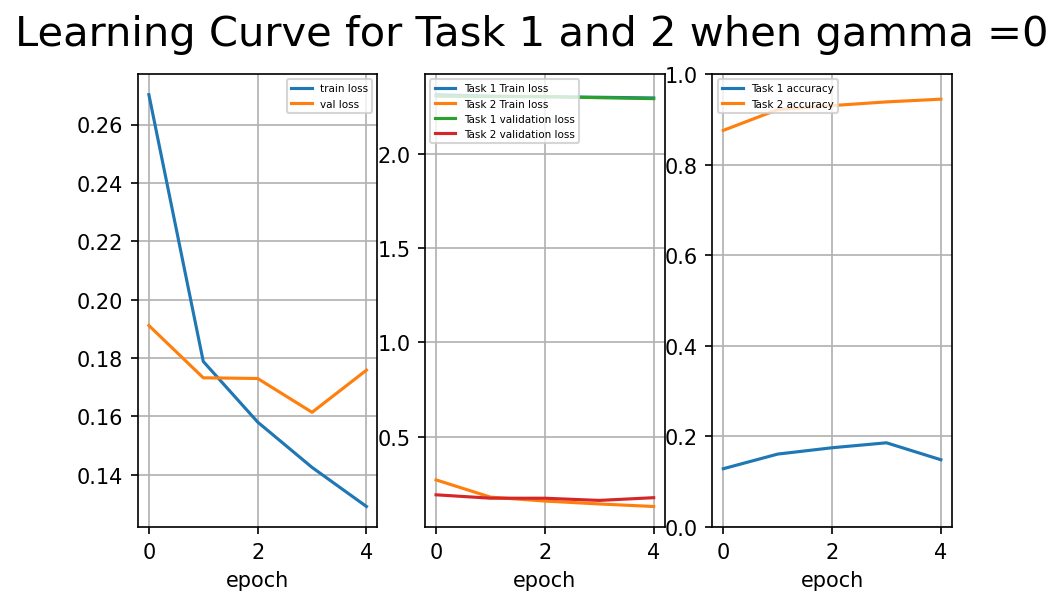


When gamma is: 0.3
Classification accuracy (Task1) on the test set: 90.27
Categorization accuracy (Task2) on the test set: 93.77


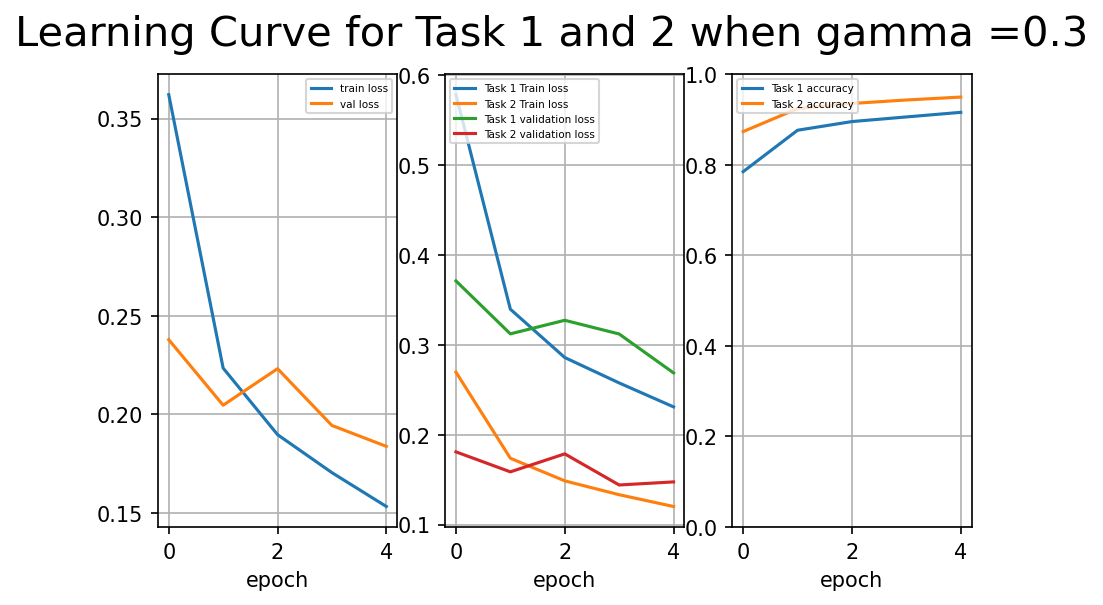


When gamma is: 0.5
Classification accuracy (Task1) on the test set: 90.14
Categorization accuracy (Task2) on the test set: 93.37


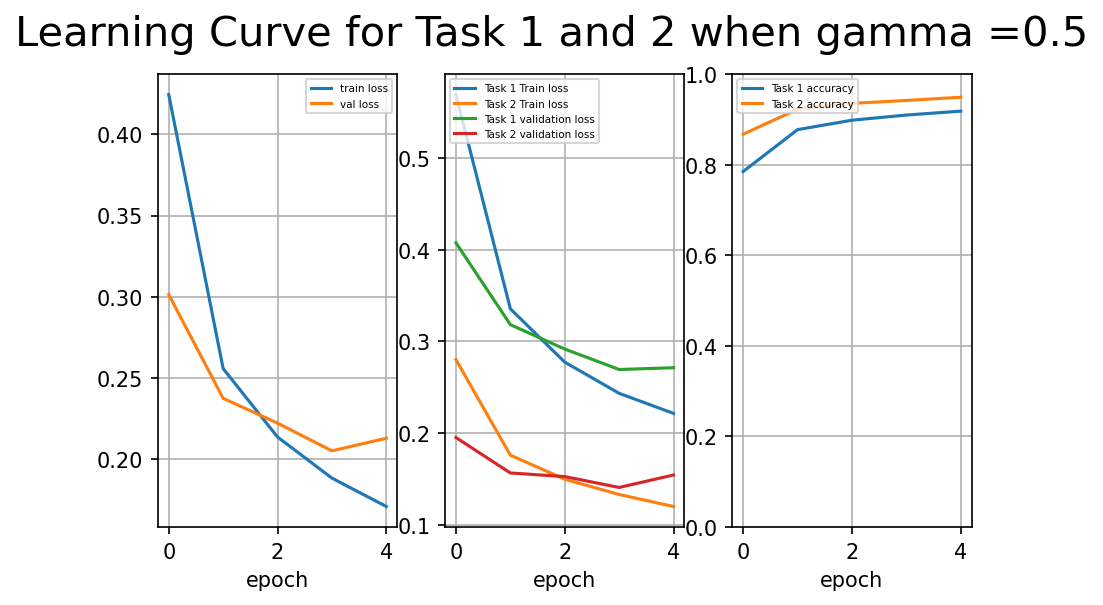


When gamma is: 0.7
Classification accuracy (Task1) on the test set: 90.32
Categorization accuracy (Task2) on the test set: 94.00


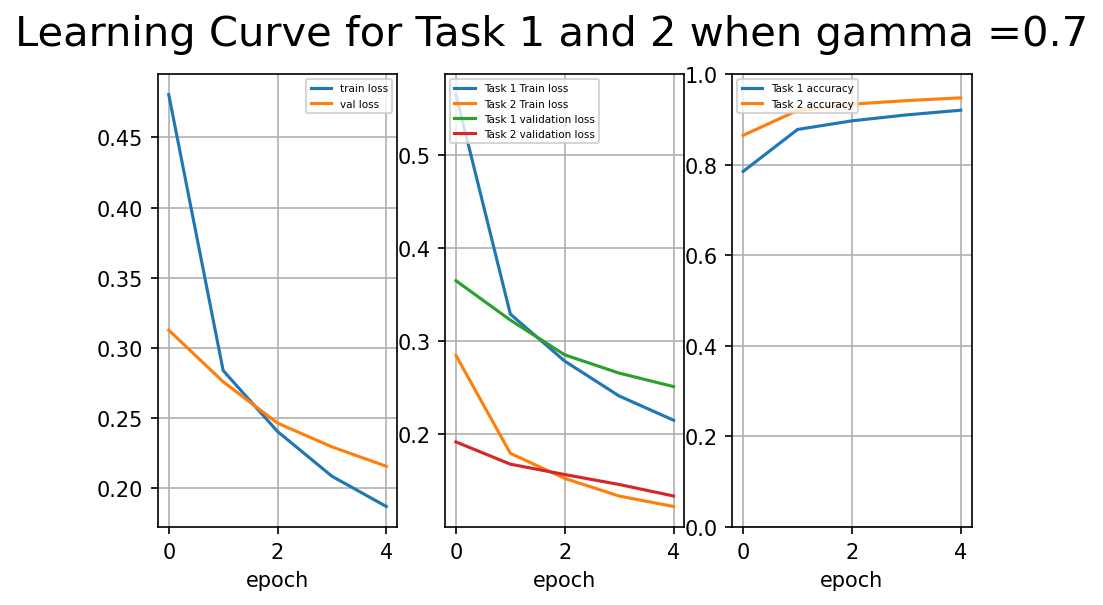


When gamma is: 1
Classification accuracy (Task1) on the test set: 89.90
Categorization accuracy (Task2) on the test set: 28.56


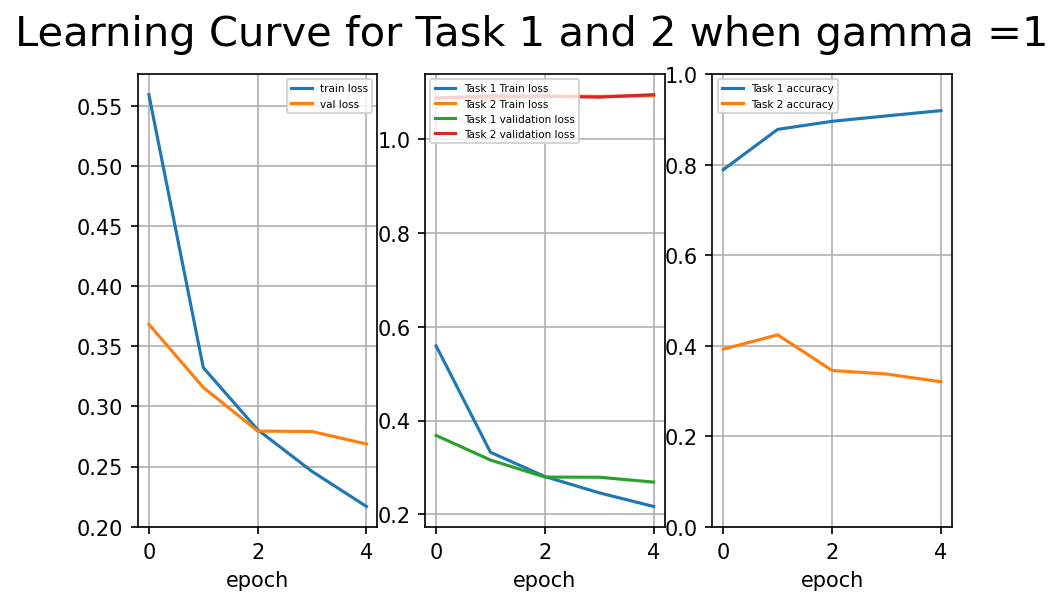

In [6]:
# with open('history_collection.pkl', 'wb') as f:
#     pickle.dump(history_collection, f)

# with open('accuracies_mtl.pkl', 'wb') as f:
#     pickle.dump(accuracies_mtl, f)

# with open('history_collection.pkl', 'rb') as f:
#     history_collection = pickle.load(f)

# with open('accuracies_mtl.pkl', 'rb') as f:
#     accuracies_mtl = pickle.load(f)

def plot_learing_curve_MTL(history, title):
    # plot the learning curves
    fig = plt.figure(figsize=(7, 4), dpi=150)
    fig.add_subplot(1,3,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(loc= 'best', prop={'size': 5})
    plt.grid(True)
    plt.xlabel('epoch')
    
    fig.add_subplot(1,3,2)
    plt.plot(history.history['classification_head_loss'], label='Task 1 Train loss')
    plt.plot(history.history['categorization_head_loss'], label='Task 2 Train loss')
    plt.plot(history.history['val_classification_head_loss'], label='Task 1 validation loss')
    plt.plot(history.history['val_categorization_head_loss'], label='Task 2 validation loss')
    plt.legend(loc=2, prop={'size': 5})
    plt.grid(True)
    plt.xlabel('epoch')
    
    fig.add_subplot(1,3,3)
    plt.plot(history.history['classification_head_accuracy'], label='Task 1 accuracy')
    plt.plot(history.history['categorization_head_accuracy'], label='Task 2 accuracy')
    plt.legend(loc=2, prop={'size': 5})
    plt.grid(True)
    plt.ylim([0,1.0])
    plt.xlabel('epoch')
    plt.suptitle(title, fontsize=20)
    plt.show()

# # It can be used to reconstruct the model identically.
for gamma, history, ac_mtl in zip([0, 0.3, 0.5 , 0.7, 1], history_collection, accuracies_mtl) :
    print('\nWhen gamma is:', gamma)
    print('Classification accuracy (Task1) on the test set: %.2f' % (ac_mtl[0]*100))
    print('Categorization accuracy (Task2) on the test set: %.2f' % (ac_mtl[1]*100))
    # plot the learning curves
    plot_learing_curve_MTL(history, f'Learning Curve for Task 1 and 2 when gamma ={gamma}')

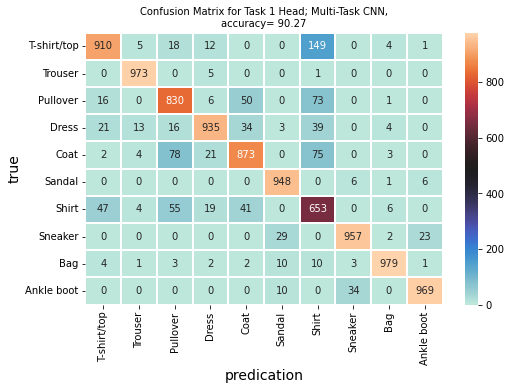

In [11]:
MTL_model = load_model('6.2_mtl_cnn_0.3.h5')
preds = MTL_model.predict(x_test, verbose = 0)
with open('accuracies_mtl.pkl', 'rb') as f:
    accuracies_mtl = pickle.load(f)
classification_accuracy_MTL, categorization_accuracy_MTL = accuracies_mtl[1]
    
plt.figure(figsize=(8, 5))
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(preds['out_class'], axis=1), np.argmax(y_test_1, axis=1)), 
            cmap='icefire', annot=True, fmt="", yticklabels=class_names, xticklabels=class_names, linewidths=0.1)
plt.xlabel('predication', fontsize = 14)
plt.ylabel('true', fontsize = 14)
plt.title('Confusion Matrix for Task 1 Head; Multi-Task CNN,\naccuracy= %.2f' %(classification_accuracy_MTL*100), fontsize=10);

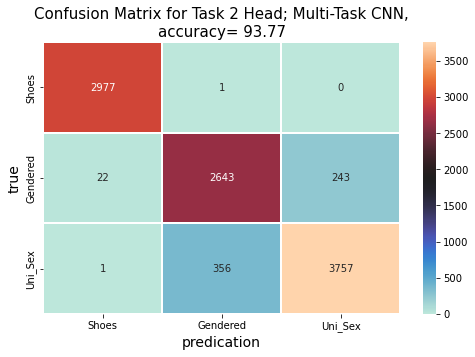

In [10]:
plt.figure(figsize=(8, 5))
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(preds['out_group'], axis=1), np.argmax(y_test_2, axis=1)), 
            cmap='icefire', annot=True, fmt="", yticklabels=groups_names, xticklabels=groups_names, linewidths=0.1)
plt.xlabel('predication', fontsize = 14)
plt.ylabel('true', fontsize = 14)
plt.title('Confusion Matrix for Task 2 Head; Multi-Task CNN,\naccuracy= %.2f' %(categorization_accuracy_MTL*100), fontsize=15);